In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn import svm, metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [4]:
rotations_num = 4
saved_name = 'selfsupervised'
selfsupervised_epochs = 100
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10
feature_layer_trained = 'add_18'
feature_layer = 'add_114'

In [5]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [6]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [7]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

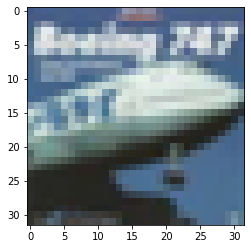

[1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


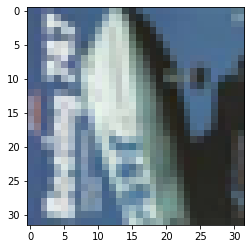

[0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


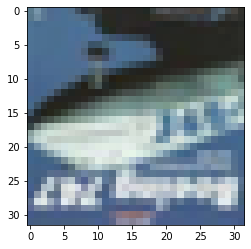

[0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


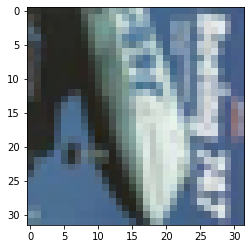

[0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
r = random.randint(0, 60000)
for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [9]:
combined_data = preprocess_input(combined_data)

In [5]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [6]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    #x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(rotations_num, activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [7]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.output
    l = layers.Flatten(name = 'conv_feat')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(128, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(128, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [27]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    return lr

In [28]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    return lr

In [29]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    return lr

In [11]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [ ]:
log = train_feat()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

In [12]:
def get_cls_model(name = saved_name, use_features = True):
    if use_features:
        model = tf.keras.models.load_model(name)
        l = model.get_layer(feature_layer_trained).output        
    else:
        model = tf.keras.models.load_model('emptyResNet')
        l = model.get_layer(feature_layer).output
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [13]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [ ]:
cls_train_features = train_cls(True)

In [ ]:
cls_no_train_features = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['acc'],
              feature_extracting_accuracy = cls_no_train_features.history['acc'])

In [ ]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_acc'],
              feature_extracting_accuracy = cls_no_train_features.history['val_acc'])

In [19]:
labelsPercent = [1, 2, 3, 5, 10, 25, 50, 100]

In [14]:
def shuffle_examples():
    #Перемешивание датасета для выбора размеченных экземпляров, т.к. выбираются первые n элементов
    for i in range(len(examplesForClass)):
        random.shuffle(examplesForClass[i])

In [15]:
def generate_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    labeled_nums = [rotations_num * i for i in range(5000 - percent * 50, 5000)]
    unlabeled_nums = [i for i in range((5000 - percent * 50) * rotations_num)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [16]:
def self_supervised_train(unlabeled, percent):
    if percent >= 100:
        return None
    
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.SGD(lr=0.1), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    log = model.fit(np.asarray([combined_data[i] for i in unlabeled]), 
                    np.asarray([combined_labels[i] for i in unlabeled]), 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, shuffle = True,
                    callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray(combined_data[50000 * rotations_num:]), 
                                               np.asarray(combined_labels[50000 * rotations_num:])))
    model.save(saved_name + "_" + str(percent))
    
    return log

In [17]:
def fine_tune(labeled, percent, train_features = True, use_features = True):
    #cls_model = get_cls_model(saved_name + "_" + str(percent))
    cls_model = get_cls_model(saved_name, use_features)
    
    if not train_features:
        flag = False
        for l in cls_model.layers:
            l.trainable = flag
            if l.name == feature_layer or l.name == feature_layer_trained:
                flag = True
                
    cls_model.summary()
            
    cls_model.compile(optimizer = optimizers.Adam(lr=0.01), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(np.asarray([combined_data[i] for i in labeled]), 
                            np.asarray([true_labels[i] for i in labeled]), 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule_cls)],
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]), 
                                               np.asarray([true_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    
    return cls_log

In [18]:
def get_empty_model():
    #Непредобученная модель на случай использования всей разметки
    model = get_conv_model()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.save(saved_name + "_100")
    
    return get_cls_model(saved_name + "_100")

In [41]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000 * rotations_num) if np.where(true_labels[j] == 1)[0][0] == i])

In [42]:
logs = []
cls_logs = []

In [43]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    #if not os.path.isfile(saved_name + "_" + str(p)):
    if not os.path.isfile(saved_name):
        logs.append(self_supervised_train(unlabeled, p))
    cls_logs.append(fine_tune(labeled, p, True))        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
________________________________________________________________________

0.009999999776482582
Epoch 1/50
1500/1500 [==============================] - 4s 3ms/sample - loss: 10.6046 - acc: 0.3273 - val_loss: 15.4582 - val_acc: 0.1768
0.009999999776482582
Epoch 2/50
1500/1500 [==============================] - 1s 410us/sample - loss: 13.6980 - acc: 0.4667 - val_loss: 14.6588 - val_acc: 0.2321
0.009999999776482582
Epoch 3/50
1500/1500 [==============================] - 1s 384us/sample - loss: 11.4904 - acc: 0.5367 - val_loss: 11.6722 - val_acc: 0.2258
0.009999999776482582
Epoch 4/50
1500/1500 [==============================] - 1s 384us/sample - loss: 8.7993 - acc: 0.6467 - val_loss: 8.8152 - val_acc: 0.4094
0.009999999776482582
Epoch 5/50
1500/1500 [==============================] - 1s 409us/sample - loss: 7.1386 - acc: 0.6827 - val_loss: 8.1405 - val_acc: 0.3787
0.009999999776482582
Epoch 6/50
1500/1500 [==============================] - 1s 419us/sample - loss: 6.4967 - acc: 0.6720 - val_loss: 7.5708 - val_acc: 0.4384
0.009999999776482582
Epoch 7/50
1500/1500 

Train on 1000 samples, validate on 10000 samples
0.009999999776482582
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/sample - loss: 9.3610 - acc: 0.2890 - val_loss: 13.6362 - val_acc: 0.2814
0.009999999776482582
Epoch 2/50
1000/1000 [==============================] - 1s 534us/sample - loss: 13.4967 - acc: 0.4320 - val_loss: 14.8331 - val_acc: 0.2829
0.009999999776482582
Epoch 3/50
1000/1000 [==============================] - 1s 561us/sample - loss: 13.3852 - acc: 0.5820 - val_loss: 14.6288 - val_acc: 0.2258
0.009999999776482582
Epoch 4/50
1000/1000 [==============================] - 1s 567us/sample - loss: 11.7702 - acc: 0.6430 - val_loss: 12.4123 - val_acc: 0.2588
0.009999999776482582
Epoch 5/50
1000/1000 [==============================] - 1s 550us/sample - loss: 9.8409 - acc: 0.7320 - val_loss: 11.0833 - val_acc: 0.3021
0.009999999776482582
Epoch 6/50
1000/1000 [==============================] - 1s 532us/sample - loss: 8.3435 - acc: 0.7320 - val_loss: 10.1512 - val_ac

In [76]:
for i in range(len(cls_logs)):
    print(cls_logs[i].history)

{'loss': [5.1621156904602055, 3.4491957165527345, 3.111892176437378, 2.836982766647339, 2.6537213677215576, 2.5163963864135743, 2.3845026907348634, 2.3148357666778563, 2.251161904144287, 2.1924621601867678, 2.1497454267883302, 2.1230961946868896, 2.095217316436768, 2.0404616275405885, 2.011863529129028, 1.9909101553344726, 1.9814020030593873, 1.9192924047088622, 1.899283710784912, 1.866166673927307, 0.8343204528808593, 0.6957590046691895, 0.7229805047416688, 0.7079862349891662, 0.7176088922500611, 0.687335565032959, 0.6569659146118164, 0.6600248963356018, 0.6057058526229858, 0.6159174393844604, 0.333522543258667, 0.20345580563545226, 0.19639107880592346, 0.1911460950088501, 0.1799638217306137, 0.18140056468963622, 0.2494173585700989, 0.19788443460464478, 0.20517555683135985, 0.2187417816734314, 0.13654079806804656, 0.1049133091878891, 0.10152696630001068, 0.09734066557884216, 0.09376265321493149, 0.08825974464416504, 0.09150181406021118, 0.08456231402397156, 0.08417600174427033, 0.0842

In [45]:
feat_log = self_supervised_train([i for i in range(50000 * rotations_num)], 0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Train on 200000 samples, validate on 40000 samples
0.10000000149011612
Epoch 1/100
200000/200000 [==============================] - 105s 524us/sample - loss: 1.7322 - acc: 0.5329 - val_loss: 1.4199 - val_acc: 0.5954
0.10000000149011612
Epoch 2/100
200000/200000 [==============================] - 99s 493us/sample - loss: 1.2233 - acc: 0.6318 - val_loss: 1.0686 - val_acc: 0.6477
0.10000000149011612
Epoch 3/100
200000/200000 [==============================] - 98s 489us/sample - loss: 0.9778 - acc: 0.6706 - val_loss: 0.9336 - val_acc: 0.6700
0.10000000149011612
Epoch 4/100
200000/200000 [==============================] - 94s 470us/sample - loss: 0.8634 - acc: 0.7002 - val_loss: 0.8934 - val_acc: 0.6769
0.10000000149011612
Epoch 5/100
200000/200000 [==============================] - 92s 461us/sample - loss: 0.7884 - acc: 0.7263 - val_loss: 0.8478 - val_acc: 0.6930
0.10000000149011612
Epoch 6/100
200000/200000 [==============================] - 97s 483us/sample - loss: 0.7256 - acc: 0.7493 -

200000/200000 [==============================] - 100s 498us/sample - loss: 0.0080 - acc: 0.9999 - val_loss: 1.5991 - val_acc: 0.7581
0.0007999999215826392
Epoch 100/100
200000/200000 [==============================] - 100s 499us/sample - loss: 0.0082 - acc: 0.9999 - val_loss: 1.6199 - val_acc: 0.7580


In [26]:
model = tf.keras.models.load_model('selfsupervised_50_backup2')
model.summary()
l = model.get_layer('conv_feat').output
feat = tf.keras.Model(inputs = model.input, outputs = l)
y_pred = []

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
________________________________________________________________________

In [28]:
features_test = feat.predict(np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]))

In [32]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    features = feat.predict(np.asarray([combined_data[i] for i in labeled]))
    clf = svm.SVC(C = 100., kernel = 'rbf')
    clf.fit(features, np.asarray([np.argmax(true_labels[i]) for i in labeled]))
    y_pred.append(clf.predict(features_test))
    print(metrics.accuracy_score(np.asarray([np.argmax(true_labels[(50000 + i) * rotations_num]) for i in range(10000)]), y_pred[-1]))

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ValueError: Found input variables with inconsistent numbers of samples: [10000, 1]

In [77]:
plot_dict = {}

for i, p in enumerate(labelsPercent):
    plot_dict["labels_" + str(p)] = cls_logs[i].history['val_acc']

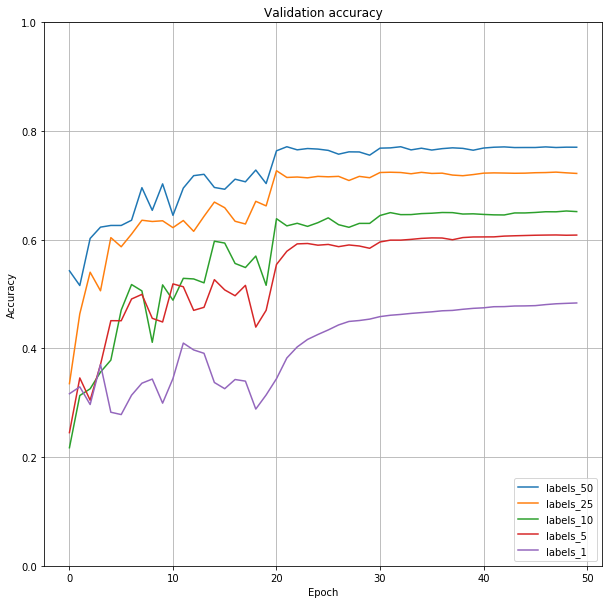

In [78]:
plot_training(name = 'Validation accuracy',
              filename = 'self_part_labels',
              **plot_dict)

In [48]:
selfsupervised_acc = {}

In [49]:
for i, p in enumerate(labelsPercent):
    selfsupervised_acc[p] = cls_logs[i].history['val_acc'][-1]
print(selfsupervised_acc)

{100: 0.8168, 50: 0.7677, 25: 0.7204, 10: 0.6401, 5: 0.6005, 1: 0.482, 3: 0.5648, 2: 0.5198}


In [101]:
emptyResNet = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
emptyResNet.summary()
emptyResNet.save('emptyResNet')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [44]:
logs_supervised = []
cls_logs_supervised = []

In [45]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    cls_logs_supervised.append(fine_tune(labeled, p, True, False))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

0.009999999776482582
Epoch 1/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 10.9415 - acc: 0.2320 - val_loss: 16.2020 - val_acc: 0.0997
0.009999999776482582
Epoch 2/50
1500/1500 [==============================] - 1s 420us/sample - loss: 14.1160 - acc: 0.3273 - val_loss: 15.7749 - val_acc: 0.1033
0.009999999776482582
Epoch 3/50
1500/1500 [==============================] - 1s 447us/sample - loss: 11.9760 - acc: 0.3993 - val_loss: 13.8559 - val_acc: 0.1168
0.009999999776482582
Epoch 4/50
1500/1500 [==============================] - 1s 417us/sample - loss: 9.2296 - acc: 0.4453 - val_loss: 9.6490 - val_acc: 0.1547
0.009999999776482582
Epoch 5/50
1500/1500 [==============================] - 1s 419us/sample - loss: 7.3037 - acc: 0.4793 - val_loss: 9.1668 - val_acc: 0.1344
0.009999999776482582
Epoch 6/50
1500/1500 [==============================] - 1s 431us/sample - loss: 6.1229 - acc: 0.5107 - val_loss: 8.9302 - val_acc: 0.1054
0.009999999776482582
Epoch 7/50
1500/1500 

Train on 1000 samples, validate on 10000 samples
0.009999999776482582
Epoch 1/50
1000/1000 [==============================] - 4s 4ms/sample - loss: 9.5924 - acc: 0.2220 - val_loss: 14.2678 - val_acc: 0.1084
0.009999999776482582
Epoch 2/50
1000/1000 [==============================] - 1s 584us/sample - loss: 13.9113 - acc: 0.3270 - val_loss: 16.1059 - val_acc: 0.1037
0.009999999776482582
Epoch 3/50
1000/1000 [==============================] - 1s 581us/sample - loss: 14.1856 - acc: 0.3820 - val_loss: 15.7970 - val_acc: 0.1003
0.009999999776482582
Epoch 4/50
1000/1000 [==============================] - 1s 577us/sample - loss: 12.7087 - acc: 0.4840 - val_loss: 14.0557 - val_acc: 0.1131
0.009999999776482582
Epoch 5/50
1000/1000 [==============================] - 1s 574us/sample - loss: 10.7536 - acc: 0.5300 - val_loss: 12.3342 - val_acc: 0.0905
0.009999999776482582
Epoch 6/50
1000/1000 [==============================] - 1s 570us/sample - loss: 8.9384 - acc: 0.5900 - val_loss: 11.2957 - val_a

In [46]:
supervised_acc = {}

In [47]:
for i, p in enumerate(labelsPercent):
    if i < len(cls_logs_supervised):
        supervised_acc[p] = cls_logs_supervised[i].history['val_acc'][-1]
print(supervised_acc)

{100: 0.8076, 50: 0.7702, 25: 0.7134, 10: 0.6265, 5: 0.5556, 1: 0.3892, 3: 0.4811, 2: 0.4377}


In [68]:
super_v = []
self_v = []

for p in labelsPercent:
    super_v.append(supervised_acc[p])
    self_v.append(selfsupervised_acc[p])

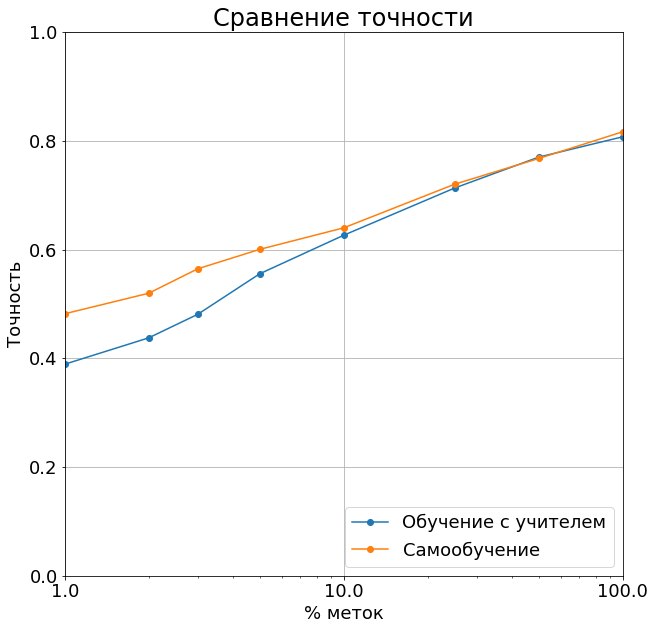

In [117]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(labelsPercent, super_v, 'o-', label='Обучение с учителем')
ax.plot(labelsPercent, self_v, 'o-', label='Самообучение')
ax.grid(True)
plt.title('Сравнение точности', size = 24)
plt.xlabel('% меток', fontsize = 18)
plt.ylabel('Точность', fontsize = 18)
plt.xscale("log")
ax.axis([1, 100, 0., 1.])
ax.tick_params(labelsize= 18)
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.legend(loc='lower right', fontsize = 18)
plt.savefig('acc_compare')

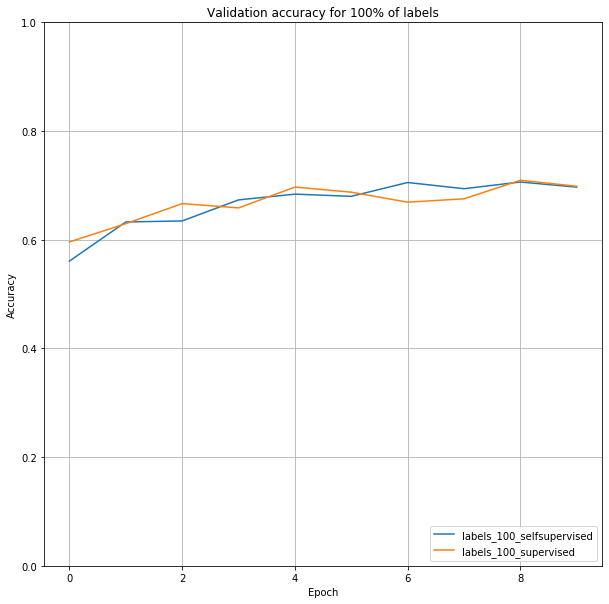

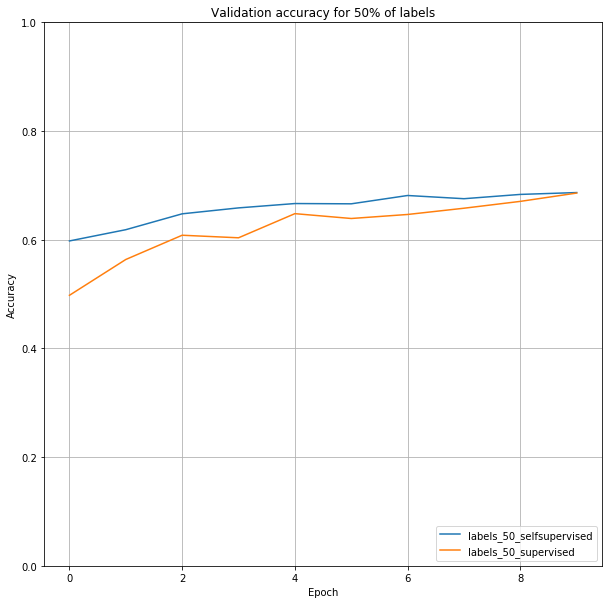

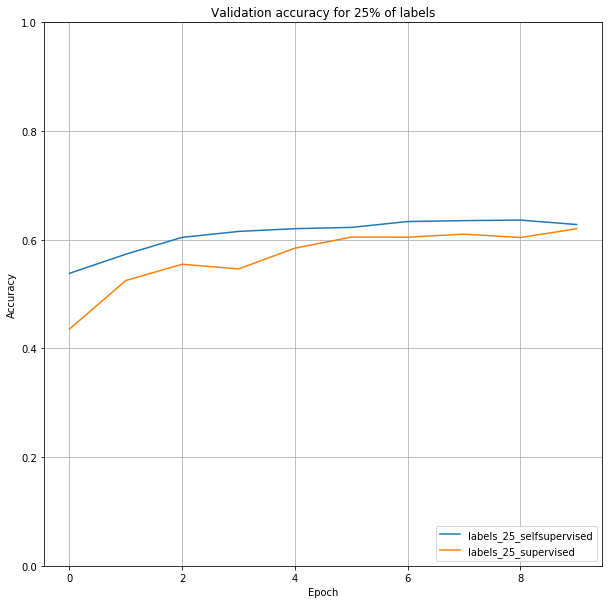

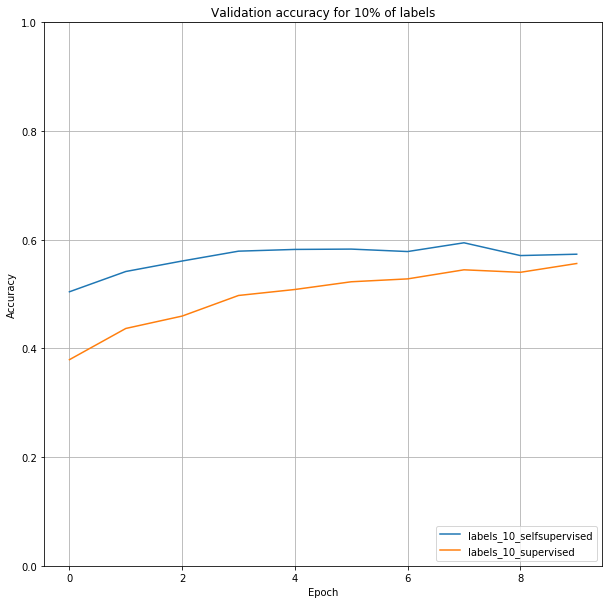

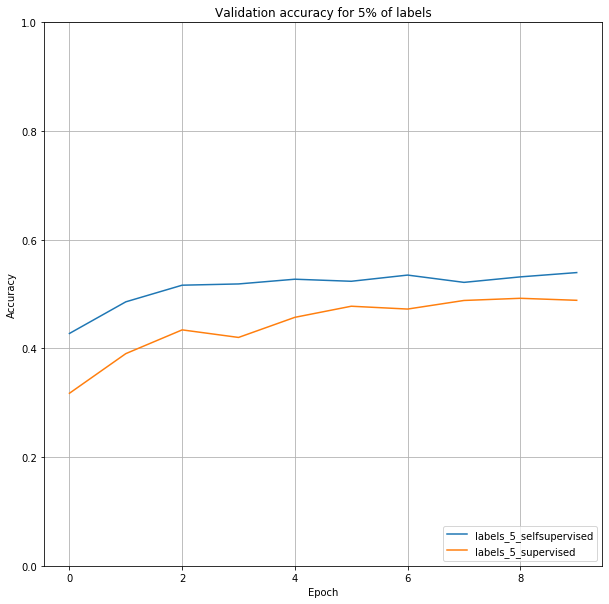

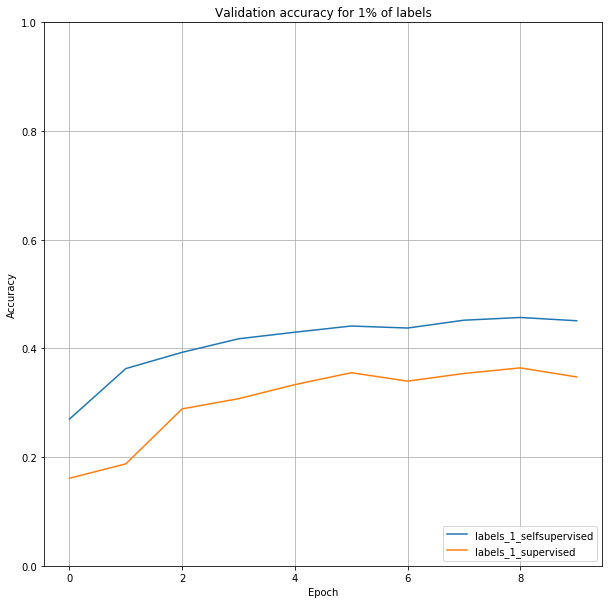

In [ ]:
for i, p in enumerate(labelsPercent):
    plot_dict = {}
    
    plot_dict["labels_" + str(p) + "_selfsupervised"] = cls_logs[i].history['val_acc']
    plot_dict["labels_" + str(p) + "_supervised"] = cls_logs_supervised[i].history['val_acc']
    
    plot_training(name = 'Validation accuracy for ' + str(p) + "% of labels",
                  filename = 'self_and_default_' + str(p) + " labels",
                  **plot_dict)

In [5]:
unsupervised_threshold = 0.95
unsupervised_loss_coef = 1.0

semisupervised_epochs = 100
semisupervised_batch_size = 128

In [6]:
labelsPercent = [50, 25, 10, 5, 3, 2, 1] #100

In [7]:
class Augmentator():
    def shearX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, (random.choice([-1, 1])) * self.M * 0.3, 0, 0, 1, 0))

    def shearY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, (random.choice([-1, 1])) * self.M * 0.3, 1, 0))

    def translateX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0], 0, 1, 0))

    def translateY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0]))

    def rotate(self, img):
        return img.rotate((random.choice([-1, 1])) * self.M * 30.0)

    def autoContrast(self, img):
        return PIL.ImageOps.autocontrast(img)

    def invert(self, img):
        return PIL.ImageOps.invert(img)

    def equalize(self, img):
        return PIL.ImageOps.equalize(img)

    def solarize(self, img):
        return PIL.ImageOps.solarize(img, self.M * 256.0)

    def posterize(self, img):
        return PIL.ImageOps.posterize(img, int(self.M * 4.0))

    def contrast(self, img):
        return PIL.ImageEnhance.Contrast(img).enhance(self.M)

    def color(self, img):
        return PIL.ImageEnhance.Color(img).enhance(self.M)

    def brightness(self, img):
        return PIL.ImageEnhance.Brightness(img).enhance(self.M)

    def sharpness(self, img):
        return PIL.ImageEnhance.Sharpness(img).enhance(self.M)
    
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.transformations = [self.autoContrast, self.equalize, self.rotate, self.solarize, self.color, self.posterize, self.contrast, self.brightness, self.sharpness, self.shearX, self.shearY, self.translateX, self.translateY]

    def __call__(self, img):
        chosen_transformations = random.choices(self.transformations, k = self.N)
        for f in chosen_transformations:
            img = f(img)
        return img


In [8]:
def is_called(func):
    def newfunc(*args, **kwargs):
        print('Called func!')
        func(args, kwargs)
    return newfunc

In [9]:
def custom_loss(y_true, y_pred):
    with tf.GradientTape() as tape:
        return tf.math.reduce_sum(tf.multiply(y_true, tf.math.log(y_pred)))

In [43]:
#loss_tracker = metrics.CategoricalCrossentropy(name="loss")
acc_metric = tf.keras.metrics.Accuracy(name="acc")

#loss_tracker_supervised = metrics.CategoricalCrossentropy(name="loss_sup")
acc_metric_supervised = tf.keras.metrics.Accuracy(name="acc_sup")

#loss_tracker_unsupervised = metrics.CategoricalCrossentropy(name="loss_unsup")
acc_metric_unsupervised = tf.keras.metrics.Accuracy(name="acc_unsup")


class CustomModel(Model):
    @is_called
    def train_step(self, data):
        X, Y = data
        print(X)
        X = tf.unstack(X)

        print('Going to tape')

        x_supervised = np.asarray([combined_data[i] for i in X if i in labeled])
        x_unsupervised = np.asarray([combined_data[i] for i in X if i in unlabeled])
        x_augmented = x_unsupervised
        y_true_supervised = np.asarray([true_labels[i] for i in X if i in labeled])

        #Supervised part
        with tf.GradientTape() as tape:
            tape.watch(x_supervised)

            y_pred_supervised = self(x_supervised, training=True)  
            loss_supervised = custom_loss(y_true_supervised, y_pred_supervised)

            #Unsupervised part
            tape.watch(x_augmented)
            y_pred = self(x_unsupervised, training=False)

            #y_pred_np = tf.make_ndarray(y_pred.op.get_attr('value'))
            y_pred_unsupervised = self(x_augmented, training=True) #if max(y_pred_np[i]) > unsupervised_threshold)
            
            loss_unsupervised = custom_loss(y_pred, y_pred_unsupervised)

            #Loss
            #loss, grads = custom_loss(self, y_true_supervised, y_pred, y_pred_supervised, y_pred_unsupervised)
            loss = loss_supervised + loss_unsupervised * unsupervised_loss_coef
            grads = tape.gradient(loss, self.trainable_variables)

            #Weights
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        #Metrics
        #loss_tracker_supervised.update_state(loss_supervised)
        acc_metric_supervised.update_state(y_true_supervised, y_pred_supervised)

        #loss_tracker_unsupervised.update_state(loss_unsupervised)
        acc_metric_unsupervised.update_state(y_pred, y_pred_unsupervised)

        #loss_tracker.update_state(loss)
        #acc_metric.update_state(np.concatenate(y_pred, y_true_supervised), np.concatenate(y_pred_unsupervised, y_pred_supervised))

        return {#"loss_supervised": loss_tracker_supervised.result(), 
                "acc_supervised": acc_metric_supervised.result(), 
                #"loss_unsupervised": loss_tracker_unsupervised.result(), 
                "acc_unsupervised": acc_metric_unsupervised.result()}

    @property
    def metrics(self):
        return [#loss_tracker, 
            acc_metric]



In [10]:
augmentator = Augmentator(2, random.random())

In [11]:
rotated_data = np.zeros((60000, 32, 32, 3), dtype = np.float32)
augmented_data = np.zeros((60000, 32, 32, 3), dtype = np.float32)
true_labels = np.zeros((60000, 10), dtype = np.float32)

In [12]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[data_len * i + j][files[i][b"labels"][j]] = 1.
        for k in range(files[i][b"data"].shape[1]):
            rotated_data[data_len * i + j][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        rotated_data[data_len * i + j] = np.rot90(rotated_data[data_len * i + j], random.choice([0, 1, 2, 3]))

In [13]:
for i in range(augmented_data.shape[0]):
    augmented_data[i] = np.array(augmentator(Image.fromarray(np.uint8(rotated_data[i]))))


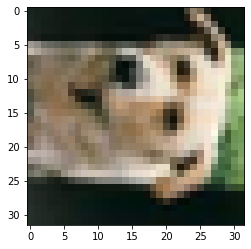

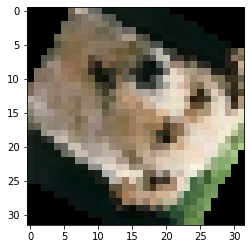

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
r = random.randint(0, 60000)
for i in range(1):
    plt.imshow(rotated_data[r + i].astype(int))
    plt.show()
    plt.imshow(augmented_data[r + i].astype(int))
    plt.show()
    print(true_labels[r + i])

In [15]:
rotated_data = preprocess_input(rotated_data)
augmented_data = preprocess_input(augmented_data)

In [16]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000) if np.where(true_labels[j] == 1)[0][0] == i])

In [17]:
def get_semi_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(10, activation = 'softmax')(x)
    
    return CustomModel(inputs = inputs, outputs = x)

In [18]:
def get_resnet_model():
    base = tf.keras.models.load_model('emptyResNet')
    l = base.get_layer(feature_layer).output
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001), activation = 'softmax')(l)

    return tf.keras.Model(inputs = base.input, outputs = l)

In [44]:
logs_resnet = []
for p in labelsPercent:
    currentPercent = p
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, currentPercent, False)
    #x_supervised = tf.convert_to_tensor([combined_data[i] for i in labeled])
    #x_unsupervised = tf.convert_to_tensor([combined_data[i] for i in unlabeled])
    #x_augmented = tf.convert_to_tensor([augmented_data[i] for i in unlabeled])
    #print('X converted')

    #y_true_supervised = tf.convert_to_tensor([true_labels[i] for i in labeled])
    #y_pred = tf.constant([0.])
    #y_pred_supervised = tf.constant([0.])
    #y_pred_unsupervised = tf.constant([0.])

    model = get_resnet_model()
    model.compile(optimizer = optimizers.SGD(lr=0.05, momentum=0.9, decay=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    model.fit(tf.convert_to_tensor(combined_data[:50000]), 
                tf.convert_to_tensor(true_labels[:50000]), 
                epochs = semisupervised_epochs, batch_size = semisupervised_batch_size, shuffle = True,
                steps_per_epoch = 5,
                validation_data = (np.asarray(combined_data[50000:60000]), 
                                    np.asarray(true_labels[50000:60000])))

Shuffled
Generated
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

Instructions for updating:
Use tf.cast instead.
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[50000,64,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node bn_conv1_1/cond/FusedBatchNorm}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/dense_5_loss/broadcast_weights/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [19]:
import time

In [20]:
def generate_labeled_unlabeled_semi(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    labeled_nums = [i for i in range(5000 - percent * 50, 5000)]
    unlabeled_nums = [i for i in range(5000 - percent * 50)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [37]:
#@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        #loss_value = custom_loss(y, logits)
        loss_value = loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    y_argmax = tf.argmax(y)
    logits_argmax = tf.argmax(logits)
    #train_acc_metric.update_state(y_argmax, logits_argmax)
    return loss_value

In [38]:
for p in labelsPercent:
    
    model = get_resnet_model()
    model.summary()
    labeled, unlabeled = generate_labeled_unlabeled_semi(examplesForClass, p, False)
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    print(dir(optimizer))
    
    #Custom training loop
    for epoch in range(semisupervised_epochs):
        print("\nEpoch " + str(epoch) + "/" + str(semisupervised_epochs))
        start_time = time.time()
        
        last_processed_element = 0
        step = 0
        while (last_processed_element + semisupervised_batch_size <= 50000):
            labeled_batch_indices = []
            unlabeled_batch_indices = []
            for i in range(last_processed_element, last_processed_element + semisupervised_batch_size):
                if i in labeled:
                    labeled_batch_indices += [i]
                else:
                    unlabeled_batch_indices += [i]
                    
            loss_value_labeled = 0.0
            if len(labeled_batch_indices) > 0:
                loss_value_labeled = train_step(tf.convert_to_tensor(np.take(augmented_data, labeled_batch_indices, axis = 0)), 
                                                        tf.convert_to_tensor(np.take(true_labels, labeled_batch_indices, axis = 0)))
            
            loss_value_unlabeled = 0.0
            if len(unlabeled_batch_indices) > 0:
                x_batch_unlabeled = tf.convert_to_tensor(np.take(augmented_data, unlabeled_batch_indices, axis = 0))
                y_true_unlabeled = model(x_batch_unlabeled, training=False)
                #check threshold
                
                loss_value_unlabeled = train_step(x_batch_unlabeled, y_true_unlabeled)
            
            print('Step ' + str(step) + ' Loss: ' + str(loss_value_labeled) + ' | ' + str(loss_value_unlabeled))
            
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

            train_acc_metric.reset_states()
            
            optimizer.lr.assign(lr_schedule_conv(optimizer.lr, epoch))
            
            last_processed_element += semisupervised_batch_size
            step += 1

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

Step 0 Loss: 0.0 | tf.Tensor(2.7437265, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 1 Loss: 0.0 | tf.Tensor(2.9827983, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 2 Loss: 0.0 | tf.Tensor(2.9580302, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 3 Loss: 0.0 | tf.Tensor(2.9192598, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 4 Loss: 0.0 | tf.Tensor(2.9665036, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 5 Loss: 0.0 | tf.Tensor(2.8981578, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 6 Loss: 0.0 | tf.Tensor(2.992826, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 7 Loss: 0.0 | tf.Tensor(2.961347, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 8 Loss: 0.0 | tf.Tensor(2.9684448, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 9 Loss: 0.0 | tf.Tensor(3.0104415, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 10 Loss

Step 83 Loss: 0.0 | tf.Tensor(2.9357584, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 84 Loss: 0.0 | tf.Tensor(2.9676952, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 85 Loss: 0.0 | tf.Tensor(2.9343402, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 86 Loss: 0.0 | tf.Tensor(2.947836, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 87 Loss: 0.0 | tf.Tensor(2.7992957, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 88 Loss: 0.0 | tf.Tensor(2.9291625, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 89 Loss: 0.0 | tf.Tensor(2.9360137, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 90 Loss: 0.0 | tf.Tensor(2.945667, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 91 Loss: 0.0 | tf.Tensor(2.8233778, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
Step 92 Loss: 0.0 | tf.Tensor(2.8815236, shape=(), dtype=float32)
Training acc over epoch: 0.0000
0
St

KeyboardInterrupt: 